# Load libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
fastai.show_install()



```text
=== Software === 
python version  : 3.7.0
fastai version  : 1.0.29.dev0
torch version   : 1.0.0.dev20181108
nvidia driver   : 396.54
torch cuda ver  : 9.2.148
torch cuda is   : available
torch cudnn ver : 7104
torch cudnn is  : enabled

=== Hardware === 
nvidia gpus     : 1
torch available : 1
  - gpu0        : 11178MB | GeForce GTX 1080 Ti

=== Environment === 
platform        : Linux-4.15.0-39-generic-x86_64-with-debian-buster-sid
distro          : Ubuntu 18.04 Bionic Beaver
conda env       : fastai-dev
python          : /home/cortex/anaconda3/envs/fastai-dev/bin/python
sys.path        : 
/home/cortex/workspace/research/tabularLearner/code
/home/cortex/anaconda3/envs/fastai-dev/lib/python37.zip
/home/cortex/anaconda3/envs/fastai-dev/lib/python3.7
/home/cortex/anaconda3/envs/fastai-dev/lib/python3.7/lib-dynload
/home/cortex/anaconda3/envs/fastai-dev/lib/python3.7/site-packages
/home/cortex/workspace/libs/fastai
/home/cortex/anaconda3/envs/fastai-dev/lib/python3.7/site-packag

In [4]:
from fastai import *
from fastai.tabular import *
from sklearn.model_selection import train_test_split, KFold

from model import tabular_learner
from fastai.callbacks import CSVLogger

# Experiments utilities

In [5]:
def get_config_df(config):
    df = pd.DataFrame(list(itertools.product(*config.values())), columns=config.keys())
    df.index = [f'model_{i+1}' for i in range(len(df))]
    return df

In [6]:
def create_experiment(nm, path, folder='results'):
    exp_path = (path/folder/nm)
    exp_path.mkdir(exist_ok=True)
    return nm, exp_path

def record_experiment(learn, fn):
    learn.callback_fns.append(partial(CSVLogger, filename=exp_path/fn))

In [7]:
def load_results(exp_path):
    config_df = pd.read_csv(exp_path/'config.csv', index_col=0)
    param_names = config_df.columns.values
    recorder_df=[]
    for p in exp_path.ls():
        if p.name.startswith(tuple(config_df.index.values)):
            df = pd.read_csv(p)
            ind_name, fold_name = p.stem.split('-')
            df['index']=ind_name
            df['fold']=int(fold_name.split('_')[-1].split('.')[0])
            recorder_df.append(df)
    recorder_df = pd.concat(recorder_df)
    metric_names = list(set(recorder_df.columns).symmetric_difference(['index', 'epoch', 'train_loss', 'fold']))
    recorder_df = recorder_df.merge(config_df.reset_index())
    return config_df, recorder_df, param_names, metric_names

def summarise_results(recorder_df, param_names, metric_names):
    return (recorder_df.groupby(['index', *param_names, 'epoch'], as_index=False)
            .agg({k:['mean', 'std'] for k in metric_names}))

In [53]:
def plot_best(summary_df, param_names, metric_names, ylim1=None, ylim2=None):
    mean_df = (summary_df.groupby(['index']).tail(1)
               .pivot(index=param_names[0], columns=param_names[1], 
                      values=[(metric_names[0], 'mean'), (metric_names[1], 'mean')]))
    sigma_df = (summary_df.groupby(['index']).tail(1)
                .pivot(index=param_names[0], columns=param_names[1], 
                       values=[(metric_names[0], 'std'), (metric_names[1], 'std')]))

    fig, ax = plt.subplots(1, len(metric_names), figsize=(20,6))
    for i, met in enumerate(metric_names):
        mu = mean_df[((met, 'mean'),)]
        sigma = sigma_df[((met, 'std'),)]
        for j in range(mu.shape[1]):
            ax[i].plot(mu.iloc[:,j], label=mu.columns[j])
            ax[i].fill_between(mu.index, mu.iloc[:,j]-sigma.iloc[:,j], mu.iloc[:,j]+sigma.iloc[:,j], alpha=0.3)
            ax[i].set_ylabel(met)
            ax[i].set_xlabel(mu.index.name)
            ax[i].legend(title=param_names[1])
            ax[i].set_xticks(mu.index)
    if ylim1: ax[0].set_ylim(ylim1)
    if ylim2: ax[1].set_ylim(ylim2)

In [54]:
def plot_over_epochs(summary_df, param_names, metric_names, config_df, ylim1=None, ylim2=None):
    mean_df = summary_df.pivot(index='epoch', columns='index', 
                               values=[(metric_names[0], 'mean'), (metric_names[1], 'mean')])
    sigma_df = summary_df.pivot(index='epoch', columns='index', 
                                values=[(metric_names[0], 'std'), (metric_names[1], 'std')])

    fig, ax = plt.subplots(1, len(metric_names), figsize=(20,6))
    for i, met in enumerate(metric_names):
        mu = mean_df[((met, 'mean'),)]
        sigma = sigma_df[((met, 'std'),)]
        for j in range(mu.shape[1]):
            ax[i].plot(mu.iloc[:,j], label=f"({','.join([str(p) for p in config_df.loc[mu.columns[j]]])})")
            ax[i].fill_between(mu.index, mu.iloc[:,j]-sigma.iloc[:,j], mu.iloc[:,j]+sigma.iloc[:,j], alpha=0.3)
            ax[i].set_ylabel(met)
            ax[i].set_xlabel(mu.index.name)
            ax[i].legend(title=f"({','.join(param_names)})")
            ax[i].set_xticks(mu.index)
    if ylim1: ax[0].set_ylim(ylim1)
    if ylim2: ax[1].set_ylim(ylim2)

# Read in Data

In [10]:
path = Path('../data')

In [11]:
df = pd.read_csv('../data/adult.csv')

In [12]:
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>=50k
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,1
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,1
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,0


# Preprocessing

## Define column types

In [13]:
dep_var = '>=50k'
num_vars = ['age', 'fnlwgt', 'education-num']
cat_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']

In [14]:
df = df.loc[:, num_vars+cat_vars+[dep_var]]

In [15]:
df.shape

(32561, 10)

## Global Parameters

In [16]:
bs=1024

procs = [FillMissing, Categorify, Normalize]

kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Validating

In [74]:
_, valid_ids = next(kf.split(df))

In [75]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

data = (src.split_by_idx(valid_ids)
        .label_from_df(cols=dep_var)
        .databunch(bs=bs))

In [82]:
learn = tabular_learner(data, layers=[200,200], act_func='selu', residual=True, mixup_aug=True, 
                        metrics=accuracy, callback_fns=[partial(CSVLogger, filename='temp.csv')])

In [77]:
learn.lr_find()
learn.recorder.plot()

In [83]:
learn.fit_one_cycle(5, 1e-3)

Total time: 01:28
epoch  train_loss  valid_loss  accuracy
1      0.451558    0.377077    0.828804  (00:17)
2      0.435567    0.376025    0.829418  (00:17)
3      0.438344    0.360038    0.838170  (00:17)
4      0.429486    0.352548    0.839705  (00:17)
5      0.424058    0.352655    0.839091  (00:17)



# Test experiment

In [15]:
experiment_name, exp_path = create_experiment('test', path)

In [153]:
config={'n_layers':[1,2], 'layer_size':[32,64]}
config_df = get_config_df(config)

In [163]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [164]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=bs))

        learn = tabular_learner(data, layers=[params['layer_size']]*params['n_layers'], metrics=accuracy)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(2, 1e-2)

Total time: 00:19
epoch  train_loss  valid_loss  accuracy
1      0.369093    0.350764    0.839681  (00:09)
2      0.371728    0.347857    0.841063  (00:09)



In [25]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

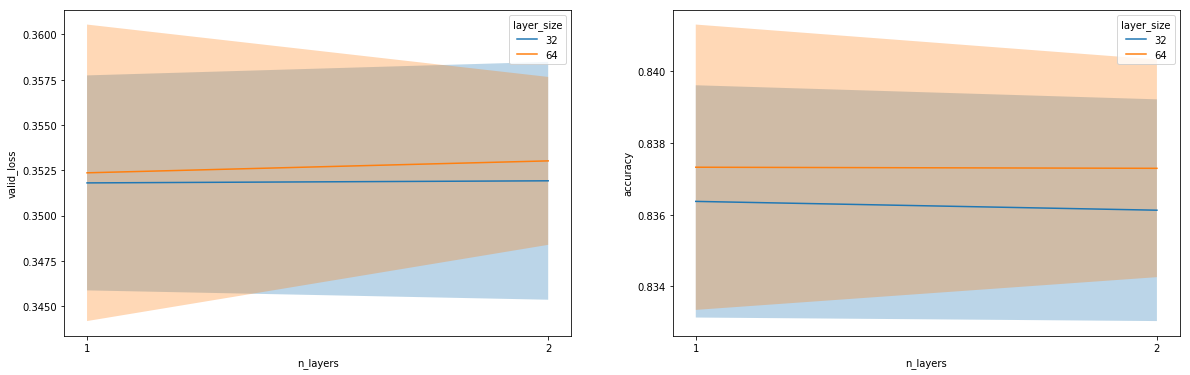

In [26]:
plot_best(summary_df, param_names, metric_names)
plt.savefig(exp_path/'best.png', bbox_inches='tight')

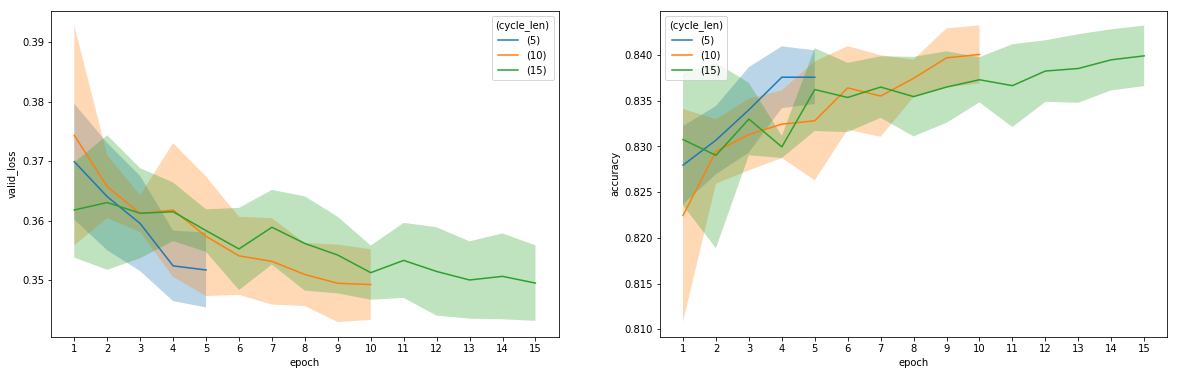

In [34]:
plot_over_epochs(summary_df, param_names, metric_names, config_df)
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# 1Cycle

In [59]:
experiment_name, exp_path = create_experiment('onecycle_batchsize', path)

In [35]:
config={'cycle_len':[5,10,20], 'batch_size':[64,256,1024]}
config_df = get_config_df(config)

In [36]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [37]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=int(params['batch_size'])))

        learn = tabular_learner(data, layers=[256]*3, metrics=accuracy)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(params['cycle_len'], 1e-2)

Total time: 00:13
epoch  train_loss  valid_loss  accuracy
1      0.581817    0.635188    0.803133  (00:00)
2      0.494004    0.421146    0.806511  (00:00)
3      0.424890    0.366612    0.824324  (00:00)
4      0.392426    0.352371    0.832002  (00:00)
5      0.376917    0.367902    0.834613  (00:00)
6      0.366896    0.354388    0.829238  (00:00)
7      0.359786    0.352896    0.832617  (00:00)
8      0.356821    0.348270    0.838452  (00:00)
9      0.353085    0.344910    0.837070  (00:00)
10     0.349228    0.345127    0.837224  (00:00)
11     0.346859    0.343187    0.840448  (00:00)
12     0.343357    0.345839    0.838759  (00:00)
13     0.340485    0.354100    0.828931  (00:00)
14     0.337175    0.349769    0.841830  (00:00)
15     0.333308    0.350359    0.838913  (00:00)
16     0.328539    0.354650    0.836609  (00:00)
17     0.324172    0.355272    0.836609  (00:00)
18     0.319596    0.360212    0.833845  (00:00)
19     0.316158    0.361013    0.837377  (00:00)
20     0.31

In [60]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

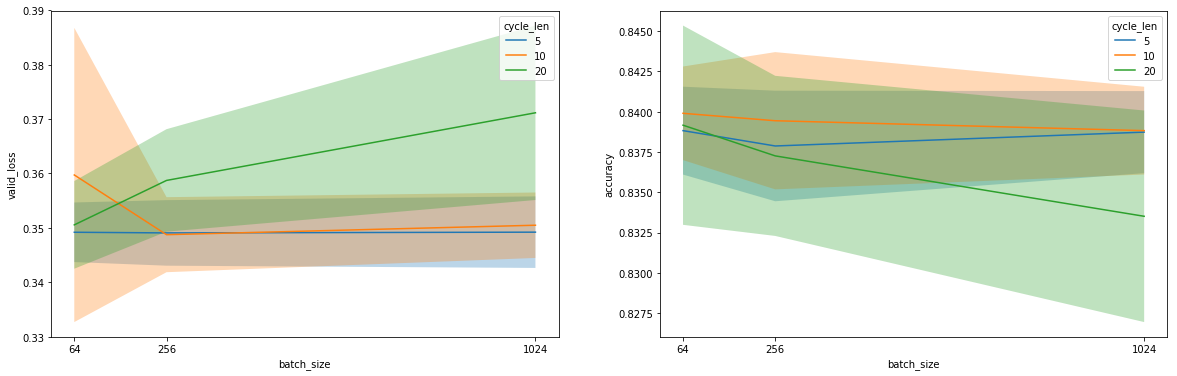

In [41]:
plot_best(summary_df, param_names[::-1], metric_names)
plt.savefig(exp_path/'best.png', bbox_inches='tight')

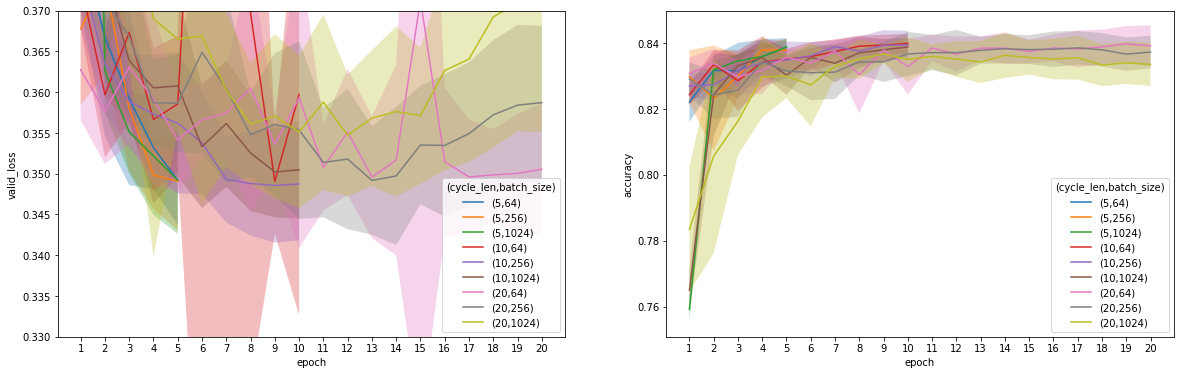

In [61]:
plot_over_epochs(summary_df, param_names, metric_names, config_df, ylim1=(0.33,0.37))
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Number and Size of Layers

In [43]:
experiment_name, exp_path = create_experiment('width_depth', path)

In [44]:
config={'layer_size':[32,128,512,2048], 'n_layer':[1,3,6,12]}
config_df = get_config_df(config)

In [45]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [46]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=256))

        learn = tabular_learner(data, layers=[params['layer_size']]*params['n_layer'], metrics=accuracy)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:31
epoch  train_loss  valid_loss  accuracy
1      0.467703    0.464636    0.748618  (00:03)
2      0.400519    0.544364    0.779791  (00:03)
3      0.378785    0.381002    0.833385  (00:03)
4      0.370281    0.480448    0.783170  (00:03)
5      0.365118    0.355163    0.832002  (00:03)
6      0.355501    2.238920    0.840909  (00:03)
7      0.356558    0.369193    0.824324  (00:03)
8      0.351012    0.348861    0.840448  (00:03)
9      0.342926    0.343829    0.841063  (00:03)
10     0.342342    0.345098    0.841370  (00:03)



In [47]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

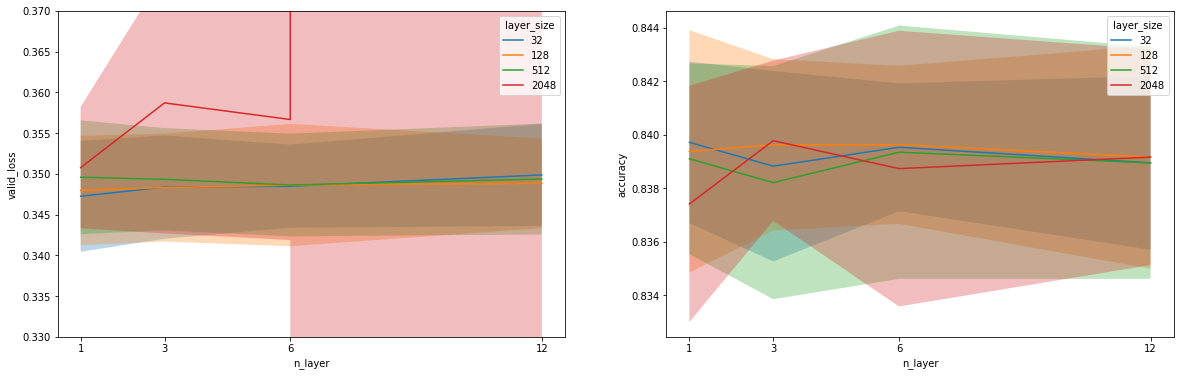

In [57]:
plot_best(summary_df, param_names[::-1], metric_names, ylim1=(0.33,0.37))
plt.savefig(exp_path/'best.png', bbox_inches='tight')

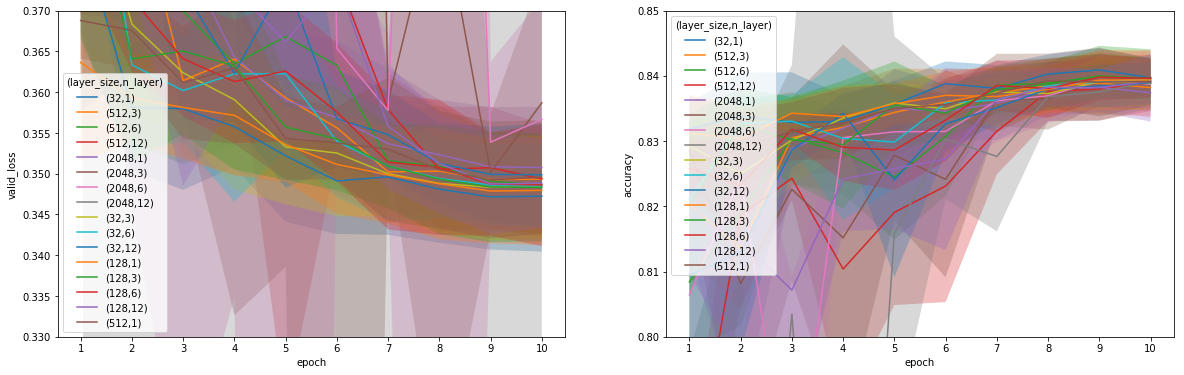

In [58]:
plot_over_epochs(summary_df, param_names, metric_names, config_df, ylim1=(0.33,0.37), ylim2=(0.8,0.85))
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Dropout

In [62]:
experiment_name, exp_path = create_experiment('size_dropout', path)

In [63]:
config={'layer_size':[128,1024], 'dropout':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]}
config_df = get_config_df(config)

In [64]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [69]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=256))

        learn = tabular_learner(data, layers=[int(params['layer_size'])]*3, ps=[params['dropout']]*3, metrics=accuracy)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:10
epoch  train_loss  valid_loss  accuracy
1      0.488618    0.377801    0.804361  (00:01)
2      0.425288    0.357577    0.829853  (00:01)
3      0.410701    0.360772    0.831849  (00:01)
4      0.399280    0.356600    0.830160  (00:01)
5      0.381902    0.353214    0.839066  (00:01)
6      0.375233    0.346348    0.836149  (00:01)
7      0.369507    0.346630    0.841830  (00:01)
8      0.363330    0.343923    0.840602  (00:01)
9      0.359405    0.342891    0.837991  (00:01)
10     0.357043    0.342924    0.841677  (00:01)



In [70]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

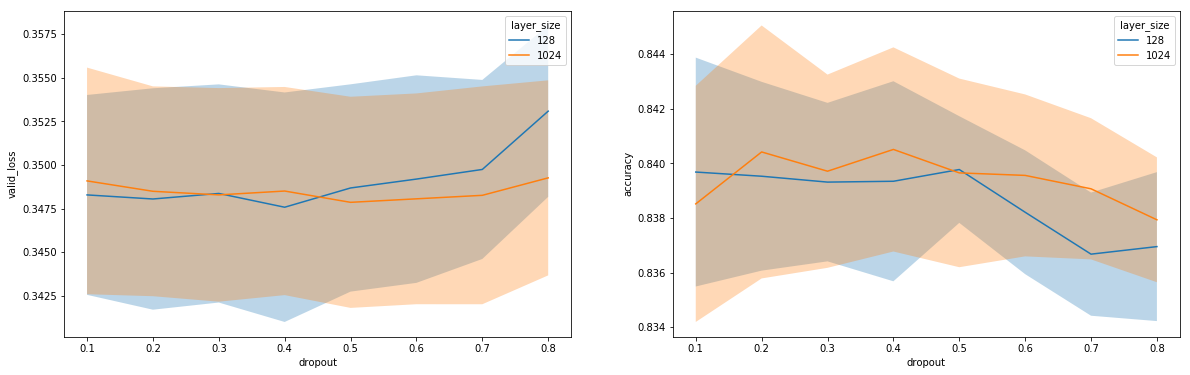

In [71]:
plot_best(summary_df, param_names[::-1], metric_names)
plt.savefig(exp_path/'best.png', bbox_inches='tight')

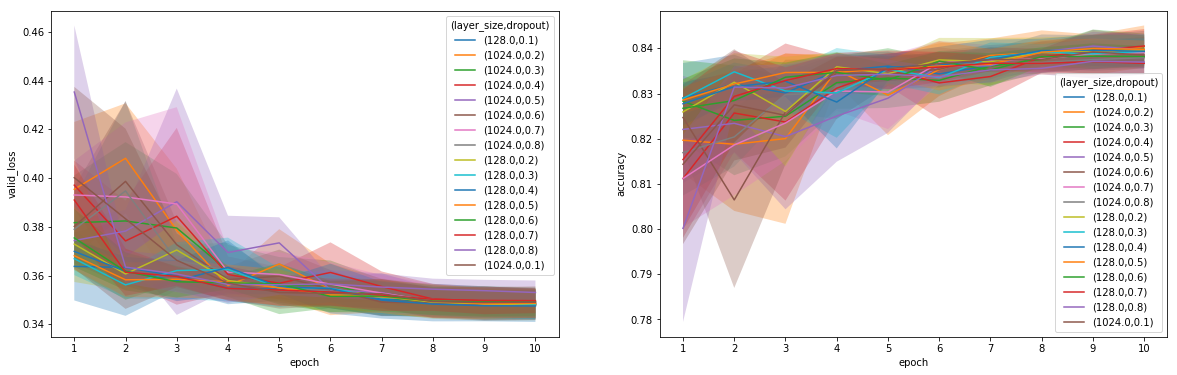

In [72]:
plot_over_epochs(summary_df, param_names, metric_names, config_df)
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Embedding Sizes

# Feature Scalings

# Sample Size

In [73]:
experiment_name, exp_path = create_experiment('samplesize', path)

In [74]:
config={'sample_size': [1000,2000,4000,8000,16000,32000]}
config_df = get_config_df(config)

In [75]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    df_sub = df.sample(params['sample_size']).copy()
    src = TabularList.from_df(df_sub, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df_sub)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=64))

        learn = tabular_learner(data, layers=[256]*3, metrics=accuracy)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:24
epoch  train_loss  valid_loss  accuracy
1      0.375712    0.362193    0.831563  (00:02)
2      0.369432    0.373252    0.829531  (00:02)
3      0.373782    0.349091    0.839688  (00:02)
4      0.369064    0.353206    0.835938  (00:02)
5      0.361587    0.357971    0.824844  (00:02)
6      0.350354    0.342558    0.843125  (00:02)
7      0.357838    0.344241    0.844688  (00:02)
8      0.335632    0.344441    0.843437  (00:02)
9      0.342440    0.343208    0.844844  (00:02)
10     0.342707    0.343508    0.845469  (00:02)



In [76]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

In [80]:
# plot_best(summary_df, param_names, metric_names)
# plt.savefig(exp_path/'best.png', bbox_inches='tight')

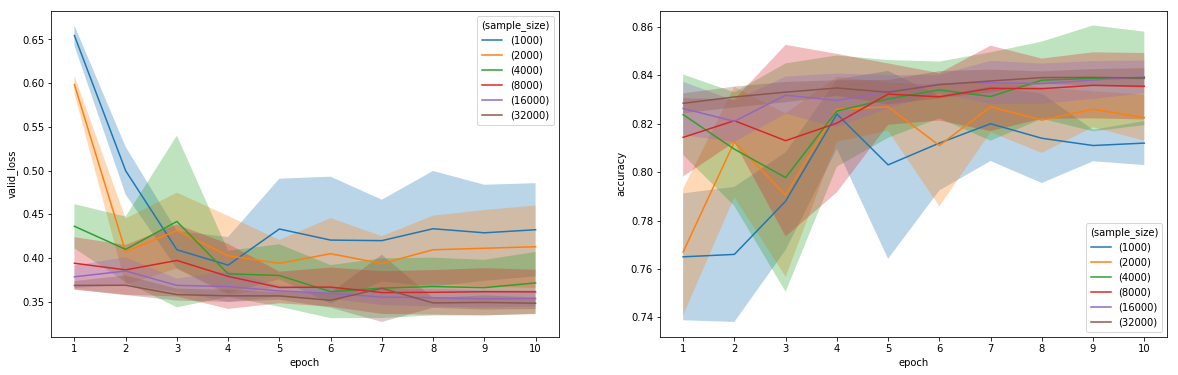

In [77]:
plot_over_epochs(summary_df, param_names, metric_names, config_df)
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Architecture Shape

# SeLU

In [83]:
experiment_name, exp_path = create_experiment('activation_depth', path)

In [88]:
config={'activation': ['relu', 'selu'], 'n_layer':[2,8]}
config_df = get_config_df(config)

In [89]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [90]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=64))

        learn = tabular_learner(data, layers=[256]*params['n_layer'], metrics=accuracy, act_func=params['activation'])
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:37
epoch  train_loss  valid_loss  accuracy   
1      0.389878    0.375866    0.838452     (00:03)
2      0.377700    0.482764    0.800061     (00:03)
3      0.380520    0.444875    0.801136     (00:03)
4      0.365862    0.447992    0.786394     (00:03)
5      0.360088    0.368305    0.833692     (00:03)
6      0.355968    0.360038    0.839834     (00:03)
7      0.359777    0.347377    0.839834     (00:03)
8      0.356928    0.345256    0.843366     (00:03)
9      0.347312    133094.859375  0.835227  (00:03)
10     0.353891    0.343132    0.840448     (00:03)



In [91]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

In [92]:
param_names

array(['activation', 'n_layer'], dtype=object)

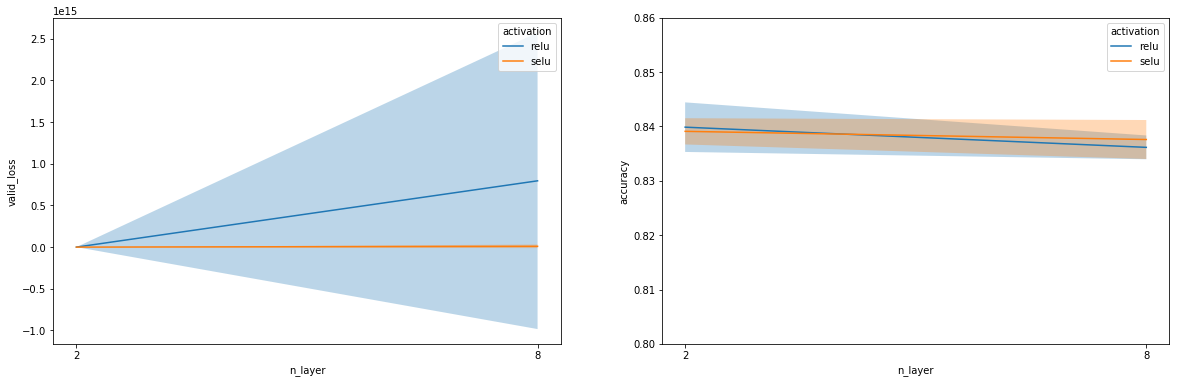

In [100]:
plot_best(summary_df, param_names[::-1], metric_names, ylim2=(0.8,0.86))
plt.savefig(exp_path/'best.png', bbox_inches='tight')

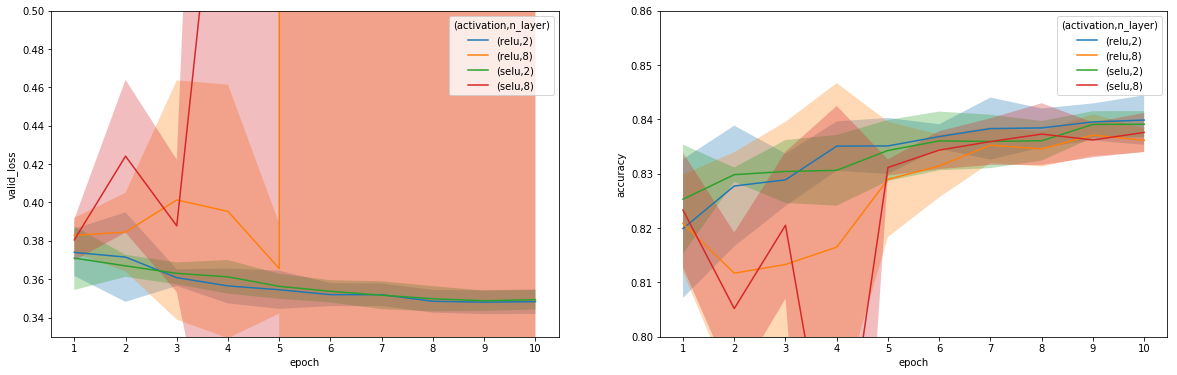

In [98]:
plot_over_epochs(summary_df, param_names, metric_names, config_df, ylim1=(0.33,0.5), ylim2=(0.8,0.86))
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Residual Connections

In [102]:
experiment_name, exp_path = create_experiment('residual_depth', path)

In [103]:
config={'residual': [False, True], 'n_layer':[2,6]}
config_df = get_config_df(config)

In [104]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [105]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=64))

        learn = tabular_learner(data, layers=[256]*params['n_layer'], metrics=accuracy, residual=params['residual'])
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:34
epoch  train_loss  valid_loss  accuracy
1      0.380711    0.374234    0.833077  (00:03)
2      0.377474    0.360787    0.837224  (00:03)
3      0.363681    0.353876    0.828931  (00:03)
4      0.360631    0.357310    0.832310  (00:03)
5      0.374947    0.352471    0.839066  (00:03)
6      0.359739    0.425140    0.837531  (00:03)
7      0.341202    0.432310    0.839373  (00:03)
8      0.339672    0.343970    0.839681  (00:03)
9      0.346132    0.342915    0.840909  (00:03)
10     0.338269    0.342827    0.841984  (00:03)



In [106]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

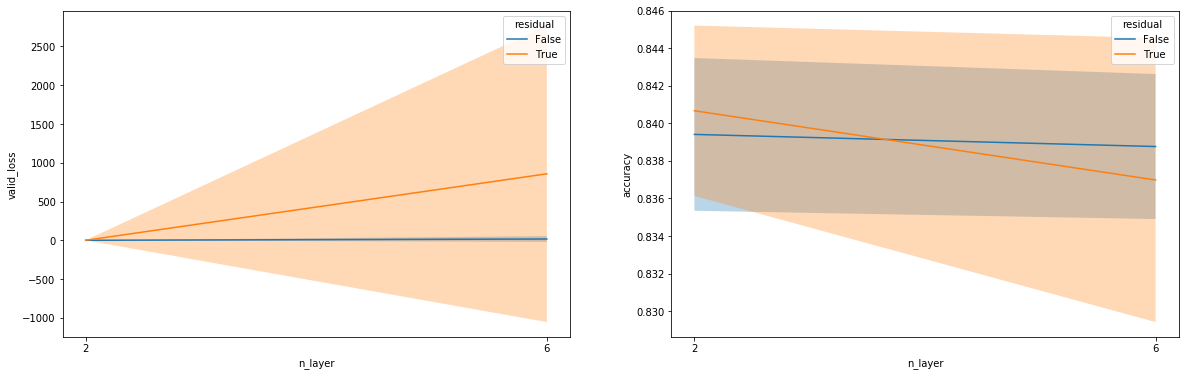

In [107]:
plot_best(summary_df, param_names[::-1], metric_names)#, ylim2=(0.8,0.86))
plt.savefig(exp_path/'best.png', bbox_inches='tight')

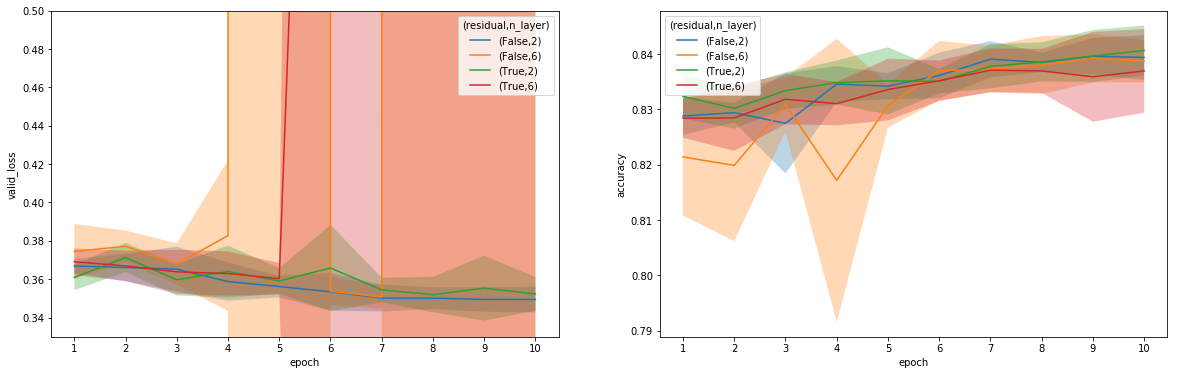

In [109]:
plot_over_epochs(summary_df, param_names, metric_names, config_df, ylim1=(0.33,0.5))#, ylim2=(0.8,0.86))
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Attention

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

# Augmentation Strategies

In [458]:
bs=1024

In [459]:
mixup_param = [False, True]

In [460]:
config = list(itertools.product(mixup_param))

In [461]:
procs = [FillMissing, Categorify, Normalize]

In [462]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [463]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [464]:
all_results = []
for j,param in enumerate(config):
    print(param)
    for i, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=bs))
        learn = tabular_learner(data, layers=[2048]*2, metrics=accuracy, mixup=param[0])
        learn.fit_one_cycle(10, 1e-2)
        results = pd.DataFrame({
            'experiment': j+1,
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

Total time: 00:08
epoch  train_loss  valid_loss  accuracy
1      0.681056    0.530435    0.766892  (00:00)
2      0.536760    0.407806    0.816646  (00:00)
3      0.491277    0.462490    0.765971  (00:00)
4      0.466968    0.359751    0.835534  (00:00)
5      0.449771    0.351057    0.837991  (00:00)
6      0.439718    0.349233    0.838145  (00:00)
7      0.434246    0.362175    0.835534  (00:00)
8      0.429932    0.362239    0.838759  (00:00)
9      0.426001    0.354755    0.840756  (00:00)
10     0.422759    0.350808    0.842138  (00:00)



In [465]:
all_results = pd.concat(all_results)
all_results['metrics']=all_results['metrics'].astype(np.float32)

In [466]:
tmp = (all_results.groupby(['experiment', 'epochs']).agg({'metrics':['mean', 'std'], 'valid_loss':['mean', 'std']}))

In [467]:
tmp.columns = [':'.join(col).strip() for col in tmp.columns.values]

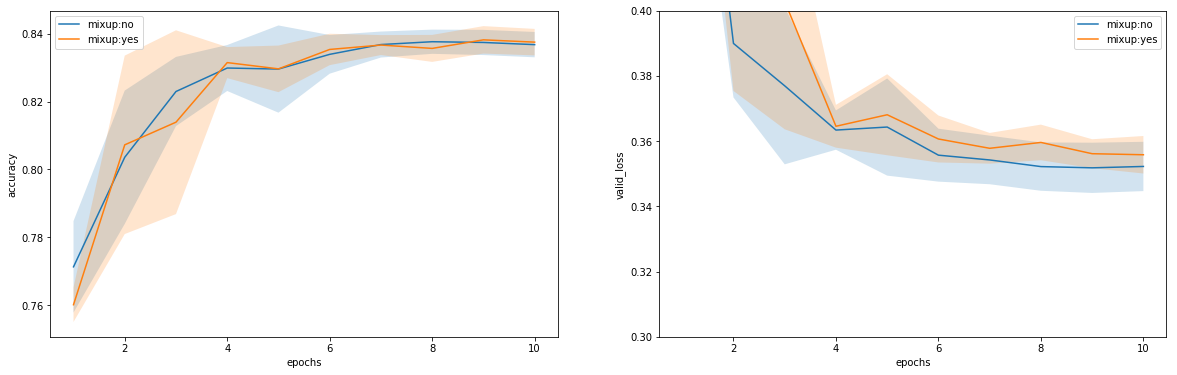

In [468]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
# plt.ylim(0.3, 0.4)
for nm,exp in tmp.groupby('experiment'):
    epochs = exp.reset_index().epochs
    mu1 = exp.reset_index()['metrics:mean']
    errors1 = exp.reset_index()['metrics:std']
    mu2= exp.reset_index()['valid_loss:mean']
    errors2 = exp.reset_index()['valid_loss:std']
    
    
    ax[0].plot(epochs,mu1, label=['mixup:no', 'mixup:yes'][nm-1])
    ax[0].fill_between(epochs, mu1-errors1, mu1+errors1, alpha=0.2)
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epochs')
    ax[1].plot(epochs,mu2,label=['mixup:no', 'mixup:yes'][nm-1])
    ax[1].fill_between(epochs, mu2-errors2, mu2+errors2, alpha=0.2)
    ax[1].set_ylim(0.3,0.4)
    ax[1].set_ylabel('valid_loss')
    ax[1].set_xlabel('epochs')
ax[0].legend()
ax[1].legend()

# Pretraining

## Process categoricals

**Note**: missing values are not yet treated

In [12]:
categories={}
for col in cat_vars:
    train_df.loc[:, col] = train_df.loc[:, col].astype('category').cat.as_ordered()
    categories.update({col:train_df.loc[:, col].cat.categories.values})
    test_df.loc[:, col] = pd.Categorical(test_df.loc[:, col], categories=categories[col], ordered=True)

still need to choose how to represent them, either one-hot or integer encoded

One-hot encode

In [13]:
for col in cat_vars:
    train_df = train_df.drop(columns=col).join(pd.get_dummies(train_df.loc[:,col], prefix=col))
    test_df = test_df.drop(columns=col).join(pd.get_dummies(test_df.loc[:,col], prefix=col))

In [14]:
train_df.head()

,age,fnlwgt,>=50k,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White
0,45,167523,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,44,126199,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,55,37438,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,34,143766,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,46,167159,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Process numerics

In [15]:
for col in num_vars:
    train_df.loc[:, col] = train_df[col].astype(np.float32)
    test_df.loc[:, col] = test_df[col].astype(np.float32)

### Choose normalisation

Standard 0 mean and unit variance scaling

In [16]:
stats={}
for col in num_vars:
    stats.update({col: np.array([train_df[col].mean(), train_df[col].std()])})
    train_df.loc[:,col] = (train_df[col]-stats[col][0])/stats[col][1]
    test_df.loc[:,col] = (test_df[col]-stats[col][0])/stats[col][1]

In [17]:
stats

{'age': array([38.588524, 13.686339]),
 'fnlwgt': array([189604.40625 , 104962.476562])}

## Dataset

In [18]:
class TabularDataset(Dataset):
    def __init__(self, df, dep_var):
        self.x = df.drop(columns=dep_var).values
        self.y = df[dep_var].values
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.get_x(idx)
        y = self.get_x(idx)
        return (x, y)
    
    def get_x(self, idx):
        return torch.tensor(self.x[idx,:], dtype=torch.float32)
    
    def get_y(self, idx):
        return torch.tensor(self.y[idx], dtype=torch.int64)

In [19]:
train_ds = TabularDataset(train_df, dep_var)
test_ds = TabularDataset(test_df, dep_var)

## Data loader

In [20]:
bs=64

In [21]:
train_dl = DataLoader(train_ds, batch_size=bs)
test_dl = DataLoader(test_ds, batch_size=bs)

In [22]:
x, y = next(iter(train_dl))

In [24]:
print(x.shape, y.shape)

torch.Size([64, 60]) torch.Size([64, 60])


In [25]:
data = DataBunch(train_dl, test_dl)

# Model

In [95]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        sizes = [60, 200, 200, 2]
        actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
        layers = []
        for i,(n_in,n_out,act) in enumerate(zip(sizes[:-1],sizes[1:],actns)):
            layers += bn_drop_lin(n_in, n_out, bn=False, p=0, actn=act)
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [43]:
class DAE(nn.Module):
    def __init__(self):
        super().__init__()
        sizes = [60, 200, 200, 60]
        actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
        layers = []
        for i,(n_in,n_out,act) in enumerate(zip(sizes[:-1],sizes[1:],actns)):
            layers += bn_drop_lin(n_in, n_out, bn=False, p=0, actn=act)
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [44]:
m = DAE()

In [45]:
m

DAE(
  (layers): Sequential(
    (0): Linear(in_features=60, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=200, out_features=60, bias=True)
  )
)

In [46]:
x_batch, y_batch = next(iter(train_dl))

In [47]:
m(x_batch).shape

torch.Size([64, 60])

In [48]:
learn = Learner(data, m, metrics=None, loss_func=F.mse_loss)

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


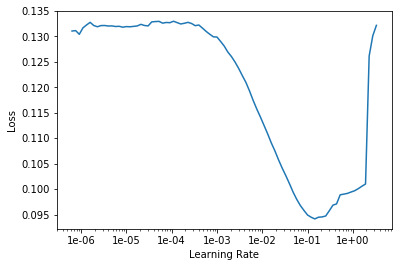

In [50]:
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(3, 1e-2)

Total time: 00:10
epoch  train_loss  valid_loss
1      0.003137    0.003181    (00:03)
2      0.000648    0.000430    (00:03)
3      0.000052    0.000055    (00:03)

